In [ ]:
#STEP 1 : INSTALLING AND LOADING LIBRARIES
# Install required libraries (only needed once)
!pip install pandas matplotlib seaborn networkx plotly requests
#1. Data Fetching & API Requests
import requests       # For making API calls (CoinGecko, Etherscan)
import json           # For handling JSON responses
#2. Data Manipulation & Analysis
import pandas as pd   # For working with tabular data
import numpy as np    # For numerical operations
#3. Visualization
import matplotlib.pyplot as plt   # For plotting time series, histograms
import seaborn as sns             # For enhanced visual styling
#4. Graph Analysis (Wallet Transactions)
import networkx as nx             # For building and visualizing wallet graphs
#5. Date & Time Handling
from datetime import datetime     # For timestamp formatting
# For anomaly detection or statistical modeling:
from scipy.stats import zscore    # For detecting outliers
#For interactive visualizations (bonus polish):
import plotly.express as px       # Optional: for interactive charts



In [ ]:
#STEP 2: Fetch Historical Cryptocurrency Data (CoinGecko):
def fetch_all_market_data(token_id='ethereum', days=30, currency='usd'):
    url = f'https://api.coingecko.com/api/v3/coins/{token_id}/market_chart'
    params = {'vs_currency': currency, 'days': days}
    response = requests.get(url, params=params).json()

    df_price = pd.DataFrame(response['prices'], columns=['timestamp', 'price'])
    df_market_cap = pd.DataFrame(response['market_caps'], columns=['timestamp', 'market_cap'])
    df_volume = pd.DataFrame(response['total_volumes'], columns=['timestamp', 'volume'])

    df = df_price.copy()
    df['market_cap'] = df_market_cap['market_cap']
    df['volume'] = df_volume['volume']
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    return df

eth_df = fetch_all_market_data()
eth_df.head()

,timestamp,price,market_cap,volume
0,2025-08-18 05:03:08.509,4341.639900,5.237417e+11,3.440608e+10
1,2025-08-18 06:03:26.527,4309.278500,5.202641e+11,3.200749e+10
2,2025-08-18 07:03:22.115,4253.453672,5.133935e+11,3.902197e+10
3,2025-08-18 08:03:45.401,4268.799745,5.143841e+11,3.813726e+10
4,2025-08-18 09:03:16.912,4254.842587,5.141890e+11,3.797259e+10


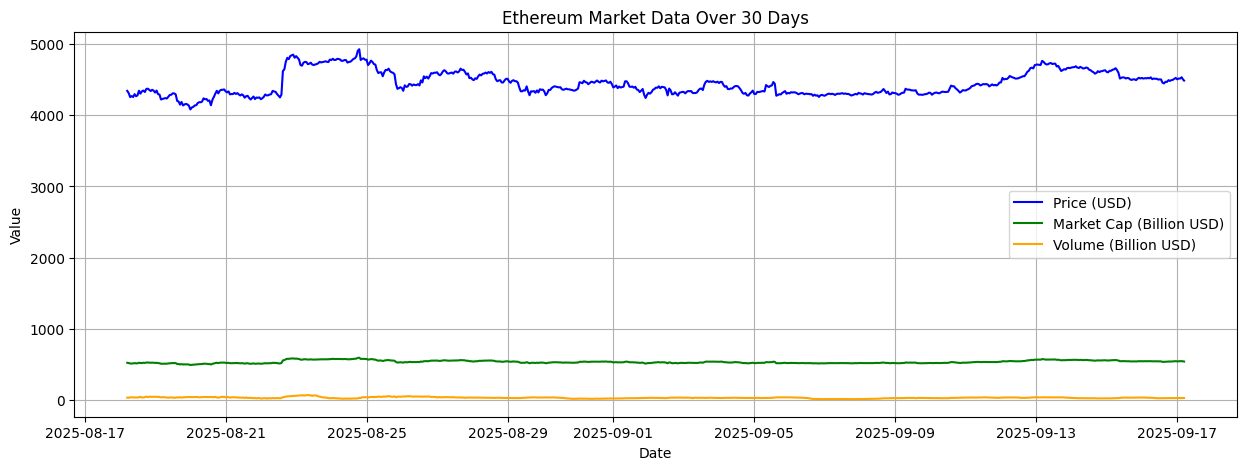

In [ ]:
# STEP 3: Visualize Price, Market Cap, Volume
plt.figure(figsize=(15, 5))
plt.plot(eth_df['timestamp'], eth_df['price'], label='Price (USD)', color='blue')
plt.plot(eth_df['timestamp'], eth_df['market_cap']/1e9, label='Market Cap (Billion USD)', color='green')
plt.plot(eth_df['timestamp'], eth_df['volume']/1e9, label='Volume (Billion USD)', color='orange')
plt.title('Ethereum Market Data Over 30 Days')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipython-input-541859425.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  eth_df['z_score'] = zscore(eth_df['price'].fillna(method='bfill'))


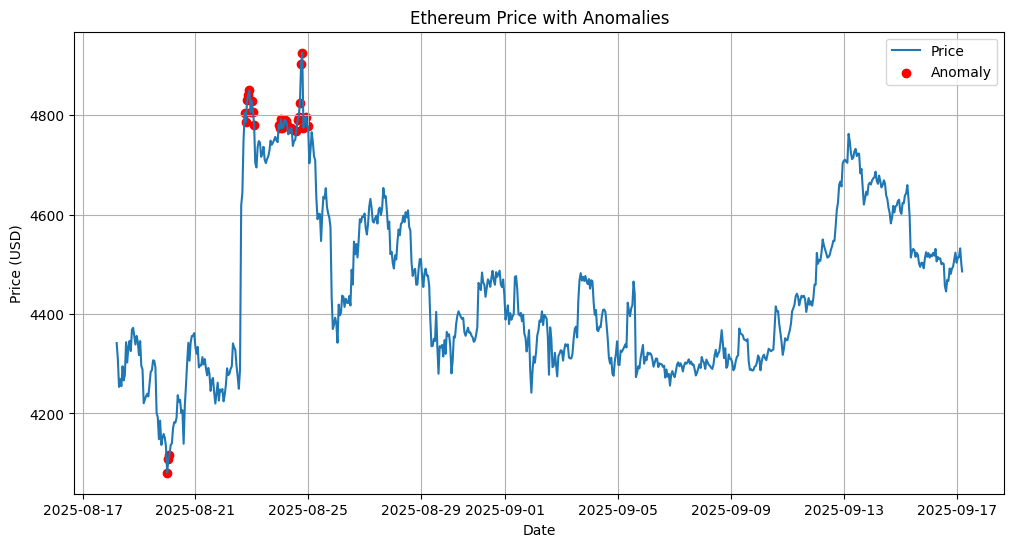

In [ ]:
#STEP 4: Detect Anomalies in Price
eth_df['price_change'] = eth_df['price'].pct_change()
eth_df['z_score'] = zscore(eth_df['price'].fillna(method='bfill'))
anomalies = eth_df[eth_df['z_score'].abs() > 2]

plt.figure(figsize=(12, 6))
plt.plot(eth_df['timestamp'], eth_df['price'], label='Price')
plt.scatter(anomalies['timestamp'], anomalies['price'], color='red', label='Anomaly')
plt.title('Ethereum Price with Anomalies')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [25]:

ETHERSCAN_API_KEY = 'IKKG4RGGNEZFQ5MQBN9J8GZ699X7TYAW2I'  # Replace with your actual key
wallet_address = '0xd8dA6BF26964aF9D7eEd9e03E53415D37aA96045'

def get_transactions(address, api_key, limit=20):
    url = f'https://api.etherscan.io/api?module=account&action=txlist&address={address}&sort=desc&apikey={api_key}'
    response = requests.get(url).json()
    txs = pd.DataFrame(response['result'][:limit])
    txs['timeStamp'] = pd.to_datetime(txs['timeStamp'], unit='s')
    txs['value'] = txs['value'].astype(float) / 1e18  # Convert from Wei to ETH
    return txs[['from', 'to', 'value', 'timeStamp']]
    tx_df = get_transactions(wallet_address, ETHERSCAN_API_KEY)
    tx_df.head()

In [31]:
# STEP 5: Query Wallet Transactions from Etherscan
ETHERSCAN_API_KEY = 'IKKG4RGGNEZFQ5MQBN9J8GZ699X7TYAW2I'  # Replace with your actual key
wallet_address = '0xd8dA6BF26964aF9D7eEd9e03E53415D37aA96045'

def get_transactions(address, api_key, limit=20):
    url = f'https://api.etherscan.io/api?module=account&action=txlist&address={address}&sort=desc&apikey={api_key}'
    response = requests.get(url).json()
    txs = pd.DataFrame(response['result'][:limit])
    txs['timeStamp'] = pd.to_datetime(txs['timeStamp'], unit='s')
    txs['value'] = txs['value'].astype(float) / 1e18  # Convert from Wei to ETH
    return txs[['from', 'to', 'value', 'timeStamp']]

    if 'value' in txs.columns:
        txs['value'] = txs['value'].astype(float) / 1e18
    else:
        txs['value'] = 0.0

    txs['timeStamp'] = pd.to_datetime(txs['timeStamp'], unit='s')
    return txs[['from', 'to', 'value', 'timeStamp']]

# This line creates tx_df
tx_df = get_transactions(wallet_address, ETHERSCAN_API_KEY)


/tmp/ipython-input-920743828.py:9: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  txs['timeStamp'] = pd.to_datetime(txs['timeStamp'], unit='s')


In [33]:
print(tx_df.head())

                                         from  \
0  0xf8fc9a91349ebd2033d53f2b97245102f00aba96   
1  0xe45564023140b24c8c46c1494051633edf27dde1   
2  0x29ce0f62c5f40361fd8f39f44efbc415f079aac2   
3  0xf8fc9a91349ebd2033d53f2b97245102f00aba96   
4  0xf8fc9a91349ebd2033d53f2b97245102f00aba96   

                                           to     value           timeStamp  
0  0xd8da6bf26964af9d7eed9e03e53415d37aa96045  0.000010 2025-09-16 10:12:11  
1  0xd8da6bf26964af9d7eed9e03e53415d37aa96045  0.000100 2025-09-16 07:03:23  
2  0xd8da6bf26964af9d7eed9e03e53415d37aa96045  0.000357 2025-09-15 21:27:59  
3  0xd8da6bf26964af9d7eed9e03e53415d37aa96045  0.000010 2025-09-15 17:55:11  
4  0xd8da6bf26964af9d7eed9e03e53415d37aa96045  0.000010 2025-09-14 10:10:23  


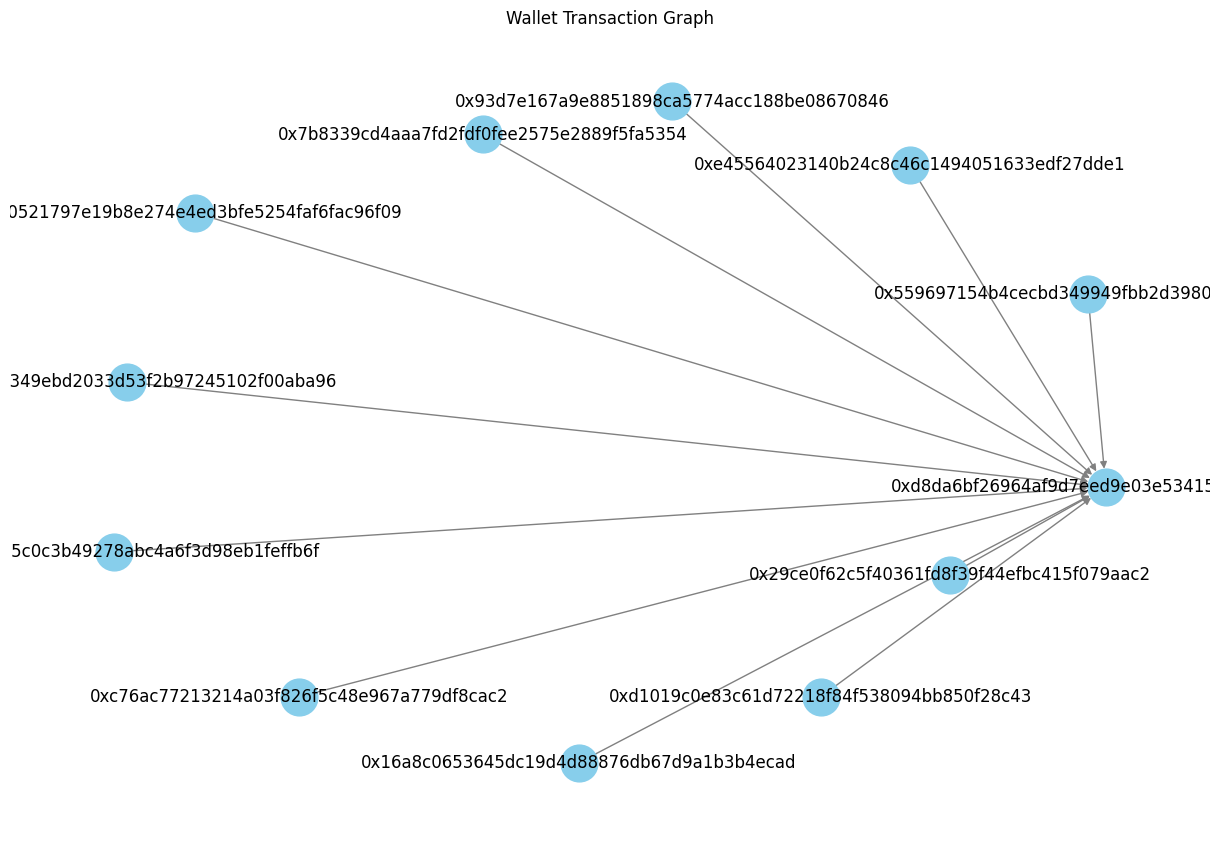

In [34]:
# STEP 6: Build Wallet Transaction Graph
def plot_wallet_graph(tx_df):
    G = nx.DiGraph()
    for _, row in tx_df.iterrows():
        G.add_edge(row['from'], row['to'], weight=row['value'])
    plt.figure(figsize=(12, 8))
    nx.draw(G, with_labels=True, node_size=700, node_color='skyblue', edge_color='gray')
    plt.title("Wallet Transaction Graph")
    plt.show()

plot_wallet_graph(tx_df)

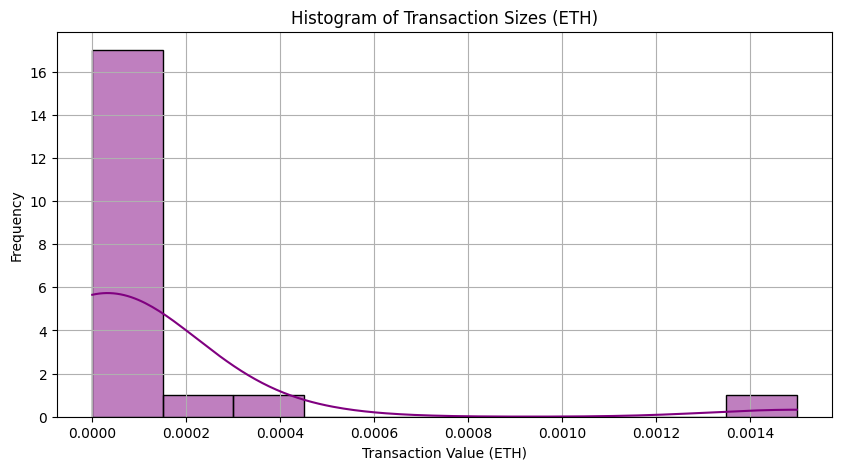

In [35]:
#  STEP 7: Forensics - Transaction Size Histogram
plt.figure(figsize=(10, 5))
sns.histplot(tx_df['value'], bins=10, kde=True, color='purple')
plt.title('Histogram of Transaction Sizes (ETH)')
plt.xlabel('Transaction Value (ETH)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()